In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_numerics
import ariel_gp
import ariel_load
import time
import numpy as np
import multiprocess
import importlib
import copy
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

local


In [2]:
train_data=kgs.load_all_train_data()
train_data=train_data

In [3]:
if False:
    R = 1125*len(train_data)
    C = 32*282

    A_row = np.memmap(kgs.temp_dir + 'AIRS_row.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='C')
    A_col = np.memmap(kgs.temp_dir + 'AIRS_col.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='F')

    R = 1105*len(train_data)
    C = 32*282

    R_row = np.memmap(kgs.temp_dir + 'AIRS_res_row.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='C')
    R_col = np.memmap(kgs.temp_dir + 'AIRS_res_col.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='F')


    loaders = ariel_load.default_loaders()
    for ii in range(2):
        loaders[ii].apply_pixel_corrections.mask_hot= False
    for ii,d in tqdm(enumerate(train_data)):
        d = copy.deepcopy(d)

        d.load_to_step(3, loaders)    
        data = d.transits[0].data[1].data

        A_row[1125*ii:1125*(ii+1),:] = data.reshape(1125,32*282).get()
        A_col[1125*ii:1125*(ii+1),:] = data.reshape(1125,32*282).get()

        residuals = ariel_numerics.remove_trend_cp(data)[10:-10,...]

        ariel_load.inpaint_vectorized(data)
        assert not cp.any(cp.isnan(data))

        x=cp.mean(data,(0,1))
        if d.planet_id == train_data[0].planet_id:
            base_scaling = x
            kgs.dill_save(kgs.calibration_dir + 'AIRS_base_scaling.pickle', base_scaling.get())
        residuals = residuals/x*base_scaling

        R_row[1105*ii:1105*(ii+1),:] = residuals.reshape(1105,32*282).get()
        R_col[1105*ii:1105*(ii+1),:] = residuals.reshape(1105,32*282).get()

        d.load_to_step(0, ariel_load.default_loaders())



        if ii%20==0:
            A_row.flush()
            A_col.flush()
            R_row.flush()
            R_col.flush()

    A_row.flush()
    A_col.flush()
    R_row.flush()
    R_col.flush()
    kgs.clear_gpu()
base_scaling = cp.array(kgs.dill_load(kgs.calibration_dir + 'AIRS_base_scaling.pickle'))

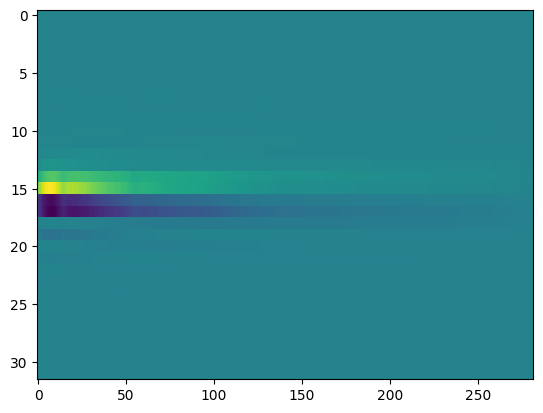

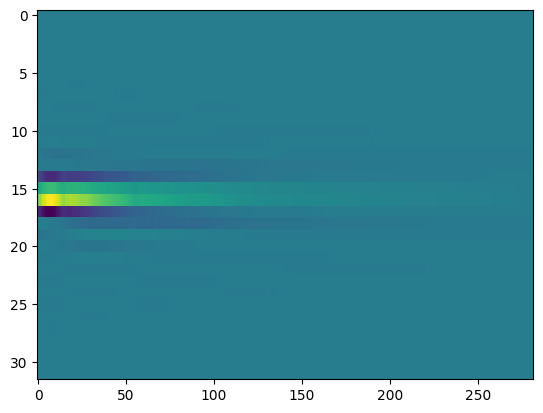

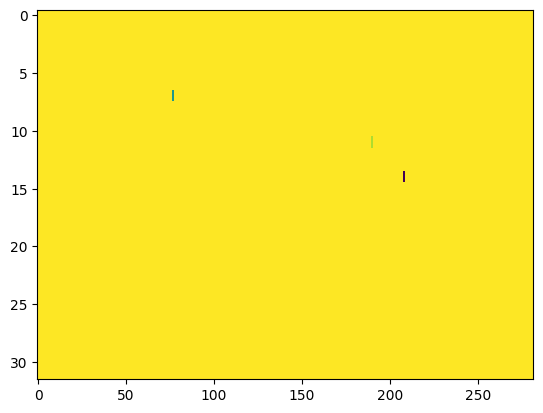

In [4]:
if False:
    R_row = np.memmap(kgs.temp_dir + 'AIRS_res_row.memmap',  dtype=np.float32, mode='r', shape=(1105*len(train_data), 32*282), order='C')#[:50000,...]
    R_col = np.memmap(kgs.temp_dir + 'AIRS_res_col.memmap',  dtype=np.float32, mode='r', shape=(1105*len(train_data), 32*282), order='F')#[:50000,...]
    import mmap
    R_row._mmap.madvise(mmap.MADV_SEQUENTIAL)
    R_col._mmap.madvise(mmap.MADV_SEQUENTIAL)
    importlib.reload(ariel_numerics)
    kgs.profiling = False
    W_combined = np.zeros((R_row.shape[0],0))
    C_combined = np.zeros((0,R_row.shape[1]))
    for ii in range(3):
        W,C,S=ariel_numerics.nan_pca_rank1_memmap(R_row, R_col, W_combined, C_combined, row_batch = 4096, col_batch = 32, verbose=True, acc_dtype=np.float32, max_iter=10)
        W_combined = np.concatenate((W_combined, W[:,None]),1)
        C_combined = np.concatenate((C_combined, C),0)
        
        
    kgs.dill_save(kgs.calibration_dir + 'AIRS_jitter.pickle', (C_combined, W_combined))

C_combined, W_combined = kgs.dill_load(kgs.calibration_dir + 'AIRS_jitter.pickle')
for ii in range(3):
    #plt.figure(figsize=(20,20))
    plt.figure()
    plt.imshow(C_combined[ii,:].reshape(32,282), aspect='auto', interpolation='none')

In [5]:
if False:
    def correct_AIRS_jitter(data):

        data_inpaint = copy.deepcopy(data)

        # Rescale
        ariel_load.inpaint_vectorized(data_inpaint)
        if kgs.debugging_mode>=1:
            assert not cp.any(cp.isnan(data_inpaint))
        x=cp.mean(data_inpaint,(0,1))
        data[...] = data/x*base_scaling
        orig_shape = data.shape   
        data = data.reshape(-1,orig_shape[1]*orig_shape[2])

        design_matrix = cp.array(C_combined)[:2,:]
        coeffs = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data.T, design_matrix.T, return_A_pinv_w=False)[0]
        data -= (design_matrix.T@coeffs).T

        # Unscale
        data = data.reshape(orig_shape)
        data[...] = data*x/base_scaling

        return data


    R_row = np.memmap(kgs.temp_dir + 'AIRS_row.memmap',  dtype=np.float32, mode='r', shape=(1125*len(train_data), 32*282), order='C')#[:50000,...]
    
    jitter_corrected_col = np.memmap(kgs.temp_dir + 'AIRS_jitter_corrected_col.memmap',  dtype=np.float32, mode='w+', shape=(10*len(train_data), 32*282), order='F')#[:50000,...]

    data = []
    for ii in tqdm(range(len(train_data))):
        #this_data = cp.array(np.mean(R_row[1125*ii:1125*(ii+1),...],0), dtype=cp.float64).reshape(1,32,282)
        
        #this_data = this_data - np.mean(this_data,0)
        #this_data = correct_AIRS_jitter(this_data)
        #data.append(this_data)
        this_data_full = cp.array(R_row[1125*ii:1125*(ii+1),...], dtype=cp.float64).reshape(-1,32,282)
        
        this_data = cp.zeros((10,32,282))
        for iii in range(10):
            this_data[iii,...] = cp.mean(this_data_full[100*iii:100*(iii+1),...],0)
        #plt.figure()
        #plt.imshow(this_data[0,...].get())
        
        #plt.figure()
        #plt.imshow(this_data[0,...].get())
        #print(np.mean(this_data,0).shape)
        this_data = correct_AIRS_jitter(this_data)
        #plt.figure()
        #plt.imshow(this_data[0,...].get())
        this_data = this_data - np.mean(this_data,0)
        jitter_corrected_col[10*ii:10*(ii+1),...] = this_data.reshape(-1,32*282).get()
        #plt.figure()
        #plt.imshow(this_data[0,...].get())
        #plt.pause(0.001)
        if ii%20==0:
            jitter_corrected_col.flush()
    jitter_corrected_col.flush()

In [6]:
# jitter_corrected_col = np.memmap(kgs.temp_dir + 'AIRS_jitter_corrected_col.memmap',  dtype=np.float32, mode='r', shape=(1125*len(train_data), 32*282), order='F').reshape(-1,32,282)
# import ariel_diagnostics
# ariel_diagnostics.animate_3d_matrix(jitter_corrected_col[::100,:,:])

In [7]:
if False:
    jitter_corrected_col = np.memmap(kgs.temp_dir + 'AIRS_jitter_corrected_col.memmap',  dtype=np.float32, mode='r', shape=(10*len(train_data), 32*282), order='F').reshape(-1,32,282)
    #data = cp.concatenate(data)
    ##data = data-cp.mean(data,0)
    #data.shape
    C0_combined = cp.zeros( (32,282) )
    for i_wavelength in tqdm(range(282)):
        this_data = cp.array(jitter_corrected_col[:,:,i_wavelength],dtype=cp.float64)
        #this_data = this_data - np.mean(this_data,0)
        C0_combined[:,i_wavelength]=ariel_numerics.nan_pca(this_data,1)[1][0,:]
        C0_combined[:,i_wavelength] = C0_combined[:,i_wavelength]*np.sign(C0_combined[15,i_wavelength])
        
    kgs.dill_save(kgs.calibration_dir + 'AIRS_C0_2.pickle', (C0_combined))
    

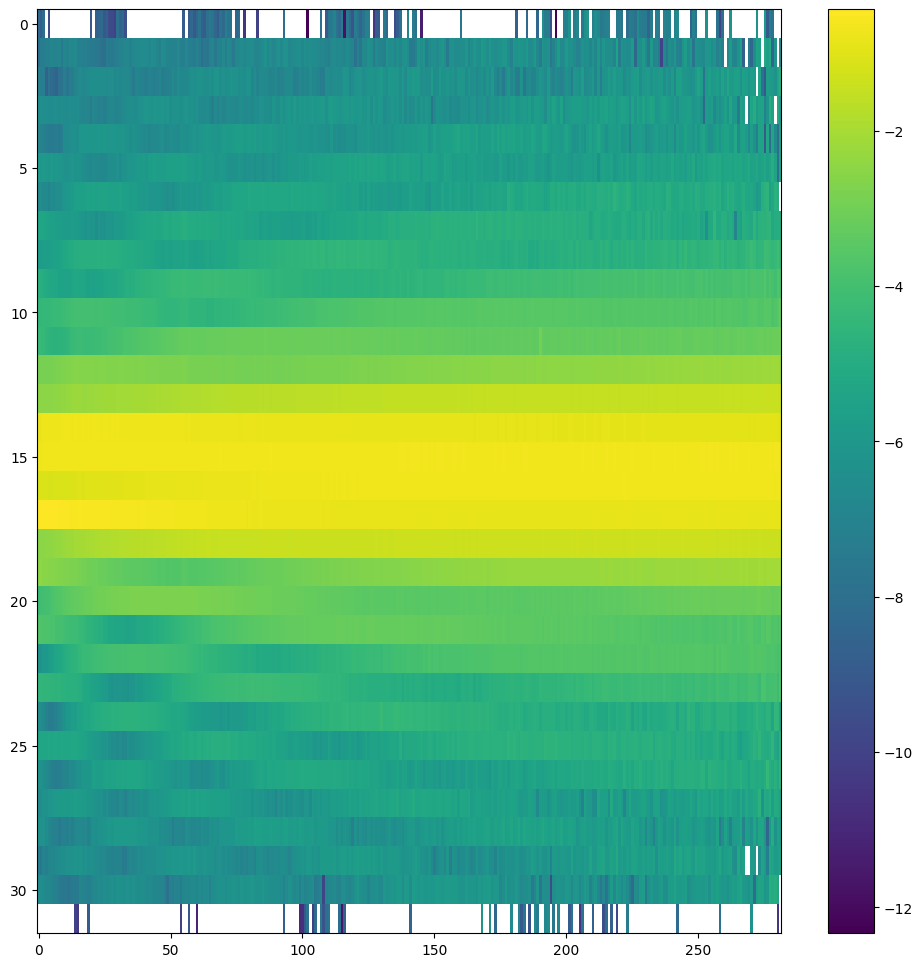

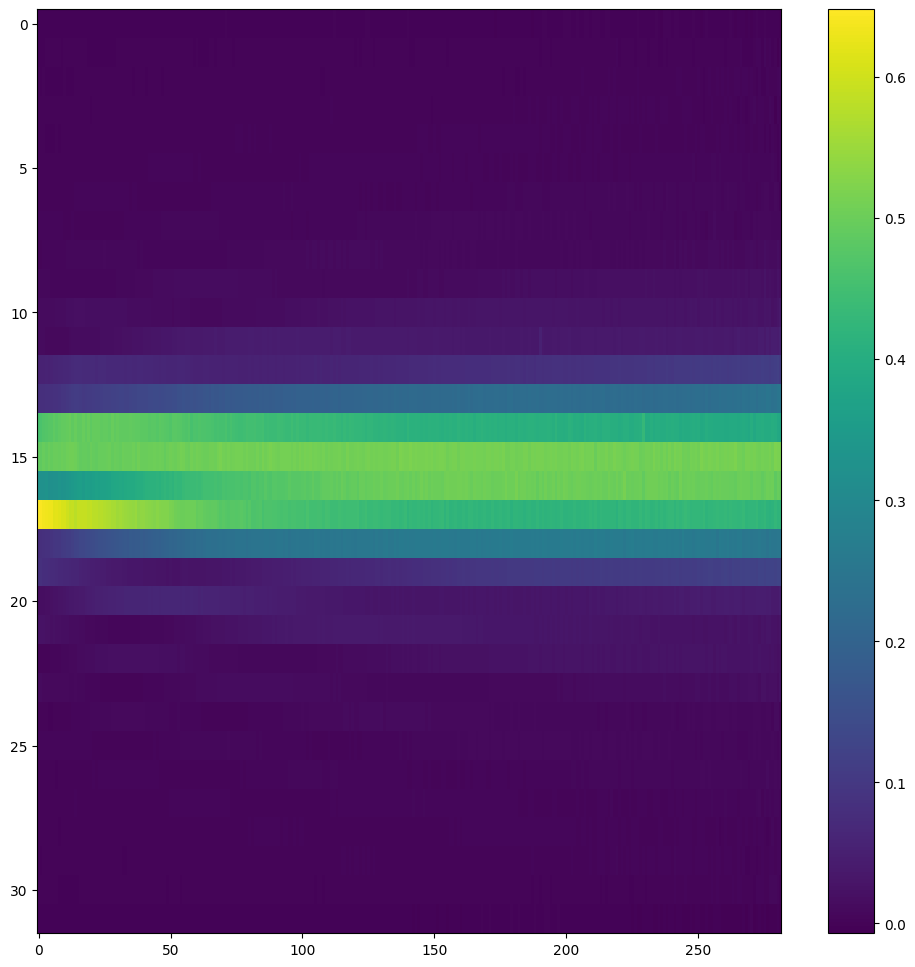

In [8]:
C0_combined = kgs.dill_load(kgs.calibration_dir + 'AIRS_C0_2.pickle')
plt.figure(figsize=(12,12))
plt.imshow(cp.log(C0_combined).get(), aspect='auto', interpolation='none')
plt.colorbar()
plt.figure(figsize=(12,12))
plt.imshow(C0_combined.get(), aspect='auto', interpolation='none')
plt.colorbar()

In [9]:
def get_coeffs(data):
    
   # data_inpaint = copy.deepcopy(data)

    # Rescale
    #ariel_load.inpaint_vectorized(data_inpaint)
    #if kgs.debugging_mode>=1:
    #    assert not cp.any(cp.isnan(data_inpaint))
    #x=cp.mean(data_inpaint,1)
    #data[...] = data/x[:,None,:]*base_scaling
    #orig_shape = data.shape   
    #data = data.reshape(-1,orig_shape[1]*orig_shape[2])
    
#    noise_est = ariel_numerics.estimate_noise_cp(data)
    
#     plt.figure()
#     plt.imshow(cp.mean(data,0).reshape(32,282).get(), interpolation='none', aspect='auto')
    
#     plt.figure()
#     plt.imshow(ariel_numerics.estimate_noise_cov_cp(data.reshape(1125,32,282)[:,:,0]).get())
#     plt.colorbar()
        

#         plt.figure()
#         plt.plot(noise_est.get())

#         design_matrix = cp.zeros((3*282,32*282))
#         #design_matrix[:2,:] = cp.array(C_combined[:2,:])
#         for i_wavelength in range(282):
#             #design_matrix[i_wavelength+2,32*i_wavelength:32*(i_wavelength+1)] = C0_combined[:,i_wavelength]
#             design_matrix[3*i_wavelength,i_wavelength::282] = C0_combined[:,i_wavelength]
#             design_matrix[3*i_wavelength+1:3*i_wavelength+2,i_wavelength::282] = C_combined[:2,:]
            
# #         plt.figure()
# #         plt.plot(cp.log(cp.sum(design_matrix,0)).get())
        
# #         plt.figure()
# #         plt.plot(cp.log(cp.sum(design_matrix,1)).get())
        
#         assert not cp.any(cp.isnan(design_matrix))
 
#         #noise_est = cp.sqrt(cp.abs(C0_combined)).flatten()
#         for ii in range(8):
#             noise_est[282*ii:282*(ii+1)]*=10000
#             #noise_est[31-ii::32]*=100
#         for ii in range(24,32):
#             noise_est[282*ii:282*(ii+1)]*=10000
#         res = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data.T, design_matrix.T, return_A_pinv_w=True, sigma=noise_est)  
#         coeffs = res[0]
        
#         A_pinv_w = res[1]
#         A_pinv_w_full = cp.zeros((284,9024))
#         A_pinv_w_full[:,~cp.isnan(data[0,:])] = A_pinv_w
#         # plt.figure()
#         # plt.plot(A_pinv_w_full[2,::282].get())
#         #plt.plot(design_matrix[2,::282].get())
#         #plt.plot((noise_est[::282]/kgs.rms(noise_est[::282])).get())
        
#         xx = noise_est[::282]/cp.sqrt(design_matrix[2,::282])
#         #plt.semilogy((xx/kgs.rms(xx)).get())
#         #print(A_pinv_w.shape, data.shape, design_matrix.shape)
#         # sens = cp.zeros((32,282))
#         # for i_wavelength in range(282):
#         #     sens[:,i_wavelength] = A_pinv_w[:]
#         #plt.figure()
#         #plt.imshow(cp.mean(residual,0).reshape(32,282).get(), aspect='auto', interpolation='none')
#         #plt.colorbar()
    
#         assert not cp.any(cp.isnan(coeffs))

#         residual = (data.T - design_matrix.T@coeffs).T
        
#         # plt.figure()
#         # plt.imshow(cp.mean(residual,0).reshape(32,282).get(), aspect='auto', interpolation='none')
#         # plt.colorbar()
        
#         noise_est = ariel_numerics.estimate_noise_cp(residual)
        
#         # plt.figure()
#         # plt.imshow(ariel_numerics.estimate_noise_cov_cp(residual.reshape(1125,32,282)[:,:,0]).get())
#         # plt.colorbar()
        
#         plt.figure()
#         plt.plot(cp.std(coeffs[2:,:],1).get())
        
       # plt.figure()
       # plt.plot(cp.mean(coeffs[2:,:],1).get())

    coeffs_wl = []
#     noise_est = cp.sqrt(cp.abs(C0_combined))#ariel_numerics.estimate_noise_cp(data.reshape(-1,32*282)).reshape(32,282)
#     noise_est[noise_est<0.1]=0.1

#     plt.figure()
#     plt.imshow(ariel_numerics.estimate_noise_cov_cp(data[:,:,0]).get())
#     plt.colorbar()
    
#     x =cp.array(C_combined[:2,:].reshape(2,32,282)[0:1,:,0])
#     plt.figure()
#     plt.imshow((x.T@x).get())
#     plt.colorbar()
    
#     x =cp.array(C_combined[:2,:].reshape(2,32,282)[1:2,:,0])
#     plt.figure()
#     plt.imshow((x.T@x).get())
#     plt.colorbar()
    
#     rhs = ariel_numerics.estimate_noise_cov_cp(data[:,:,0]).flatten()
    
    # plt.figure()
    # plt.imshow(ariel_numerics.estimate_noise_cov_cp(data[:,:,0]).get())
    # plt.colorbar()
    
    #data = 0*data+50
    
    #data+=50
    
    residualf = copy.deepcopy(data)
    
    noise_output = cp.zeros(282)
    noise_seen = cp.zeros(282)
    noise_no_jitter = cp.zeros(282)
    mean_vals = cp.zeros(282)
    
    noise_data_combined = cp.zeros((32,282))
    residual_expected = cp.zeros((32,282))
    
   # wt1 = cp.zeros((1125,282))

    for i_wavelength in range(282):
        
        isnan = cp.isnan(data[0,:,i_wavelength])
        
        rhs = ariel_numerics.estimate_noise_cov_cp(data[:,:,i_wavelength])
        
        rhs[isnan,:] = 0
        rhs[:,isnan] = 0
        
        rhs=rhs.flatten()
        
       # plt.figure()
       # plt.imshow(rhs.reshape(32,32).get())
        
        x = cp.array(C_combined[:2,:].reshape(2,32,282)[0:1,:,i_wavelength])
        #rint(x.shape, isnan.shape)
        x[:,isnan]=0
        x1 = (x.T@x).flatten()
        
        
        
        
        
        x = cp.array(C_combined[:2,:].reshape(2,32,282)[1:2,:,i_wavelength])
        x[:,isnan]=0
        x2 = (x.T@x).flatten()
        
        x = C0_combined[:,i_wavelength]
        x[isnan]=0
        x3 = (x.T@x).flatten()
        
        design_matrix = cp.zeros((32*32, 3+32))
        design_matrix[:,0] = x1
        design_matrix[:,1] = x2
        design_matrix[:,2] = x3
        for ii in range(32):
            design_matrix[33*ii,ii+3]=1
            
#         plt.figure()
#         plt.imshow(design_matrix[:,0].reshape(32,32).get())
        
#         plt.figure()
#         plt.imshow(design_matrix[:,17].reshape(32,32).get())


        coeffs = cp.linalg.lstsq(design_matrix, rhs, rcond=None)[0]
    
        residual = rhs - design_matrix@coeffs
        
        noise_est = cp.sqrt(coeffs[3:])
        
        noise_data_combined[:,i_wavelength] = noise_est
        
        # if i_wavelength==0:
        #     plt.figure()
        #     plt.plot((noise_est/cp.sqrt(C0_combined[:,i_wavelength])).get())
        #     plt.figure()
        #     plt.imshow(rhs.reshape(32,32).get())
        #     plt.colorbar()
        #     plt.figure()
        #     plt.imshow(residual.reshape(32,32).get())
        #     plt.colorbar()
            
        
        

        mean_handled = False
        while True:

            if mean_handled:
                design_matrix = cp.zeros((3,32))
                design_matrix[0,:] = C0_combined[:,i_wavelength]
                design_matrix[1:3,:] = cp.array(C_combined[:2,:].reshape(2,32,282)[:,:,i_wavelength])
                #design_matrix[3,:] = 1
            else:
                design_matrix = cp.zeros((4,32))
                design_matrix[0,:] = C0_combined[:,i_wavelength]
                design_matrix[1:3,:] = cp.array(C_combined[:2,:].reshape(2,32,282)[:,:,i_wavelength])
                design_matrix[3,:] = 1               
            
            N = design_matrix.shape[0]

            #noise_est[:,i_wavelength] = cp.sqrt(cp.abs(design_matrix[0,:]))
            #noise_est[:8,i_wavelength] *= 100000
            #noise_est[24:,i_wavelength] *= 100000
            #if ii==0:
            res = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data[:,:,i_wavelength].T, design_matrix.T, return_A_pinv_w=True, sigma=noise_est)
            #else:
            #    res = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data[:,:,i_wavelength].T, design_matrix.T, return_A_pinv_w=True, sigma=noise_est[:,i_wavelength])
            coeffs = res[0]
            
            #if i_wavelength==0:
            #     plt.figure()
            #     plt.plot(res[1].get().T[:,0])
            
          #  mapping = design_matrix.T@res[1]
            #K_diff = design_matrix
            
            # if i_wavelength==0 and ii==0:
            #     plt.figure()
            #     plt.imshow(np.eye(32)- (mapping.T@mapping).get())
            #     plt.colorbar()
                


            residualf[:,:,i_wavelength] = (data[:,:,i_wavelength].T - design_matrix.T@coeffs).T           #
            
            #print(res[1].shape, cp.diag(noise_est**2).shape)
            A_pinv_w = res[1]
            A_pinv_w_full = cp.zeros((N,32))
            A_pinv_w_full[:,~cp.isnan(data[0,:,i_wavelength])] = A_pinv_w
            noise_est[cp.isnan(data[0,:,i_wavelength])] = 0
            noise_output[i_wavelength] = cp.sqrt((A_pinv_w_full@cp.diag(noise_est**2)@A_pinv_w_full.T)[0,0])
            
            noise_seen[i_wavelength] = ariel_numerics.estimate_noise_cp(coeffs[0,:])
            
#             res2 = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data[:,:,i_wavelength].T, design_matrix[0:3,:].T, return_A_pinv_w=True, sigma=noise_est)
            
#             A_pinv_w = res2[1]
#             A_pinv_w_full = cp.zeros((3,32))
#             A_pinv_w_full[:,~cp.isnan(data[0,:,i_wavelength])] = A_pinv_w
#             noise_est[cp.isnan(data[0,:,i_wavelength])] = 0
#             noise_no_jitter[i_wavelength] = cp.sqrt((A_pinv_w_full@cp.diag(noise_est**2)@A_pinv_w_full.T)[0,0])
            
            mat = design_matrix.T@A_pinv_w_full
            #print(mat.shape)
            cov_expected = cp.diag(noise_est**2) - mat@cp.diag(noise_est**2)@mat.T
            residual_expected[:,i_wavelength] = cp.sqrt(cp.diag(cov_expected))
            
            residual_expected_ratio = cp.mean(residualf[:,:,i_wavelength],0)/residual_expected[:,i_wavelength]*np.sqrt(1125)
            residual_expected_ratio[cp.isnan(residual_expected_ratio)] = 0
            
            #if i_wavelength>200 and i_wavelength<220:
            #    print(i_wavelength, residual_expected_ratio, cp.max(cp.abs(residual_expected_ratio)))
            # if cp.max(cp.abs(residual_expected_ratio))==0:
            #     plt.figure()
            #     plt.imshow(cov_expected.get())
            #     plt.figure()
            #     #plt.plot(residual_expected[:,i_wavelength].get())
            #     plt.plot(cp.std(residualf[:,:,i_wavelength].get()))
            #     print(cp.std(residualf[:,:,i_wavelength].get()))
            #     raise 'stop'
            if cp.any(cp.abs(residual_expected_ratio)>30):
                #print(i_wavelength, cp.max(cp.abs(residual_expected_ratio)), cp.argmax(cp.abs(residual_expected_ratio)), mean_handled)
                data[:,cp.argmax(cp.abs(residual_expected_ratio)),i_wavelength] = cp.nan
            else:
                #mean_handled = True
                if not mean_handled:
                    #print(coeffs[3,:].shape)
                    data[:,:,i_wavelength]-=np.mean(coeffs[3,:])    
                    mean_vals[i_wavelength] = np.mean(coeffs[3,:])    
                    mean_handled = True
                else:
                    coeffs_wl.append(coeffs)
                    break
            # if i_wavelength==0:
            #     plt.figure()
            #     plt.imshow(cp.diag(noise_est**2).get())
            #     plt.colorbar()
            #     plt.figure()
            #     plt.imshow(cov_expected.get())
            #     plt.colorbar()

            #noise_est[:,i_wavelength] = ariel_numerics.estimate_noise_cp(residual)
            
            #H = design_matrix.T@(design_matrix@design_matrix.T)@design_matrix
            
            #if i_wavelength==281:
            #    plt.figure()
            #    plt.plot(noise_est[:,i_wavelength].get())
#             noise_est[:,i_wavelength] /= cp.sqrt(1-cp.diag(H))
#             #if i_wavelength==281:
#             #    plt.plot((noise_est[8:24,i_wavelength]/cp.sqrt(design_matrix[0,8:24])).get())
                
#             noise_est[:,i_wavelength] = cp.sqrt(cp.abs(design_matrix[0,:]))
            
#             noise_est[:8,i_wavelength]*=100000
#             noise_est[24:,i_wavelength]*=100000

            # if i_wavelength==0 and ii==0:
            #     plt.figure()
            #     plt.imshow(ariel_numerics.estimate_noise_cov_cp(residual).get())
            #     plt.colorbar()

        
            #coeffs_wl[-1] = coeffs_wl[-1] / base_scaling[i_wavelength] * x[:,i_wavelength]

    coeffs_wl = [c.T.get() for c in coeffs_wl]
    
    #print(cp.mean(residualf[:,:,i_wavelength],0)/residual_expected[:,i_wavelength])
#     plt.figure()
#     plt.imshow((cp.mean(residualf,0)/residual_expected*np.sqrt(1125))[:,:].get(), interpolation='none', aspect='auto')
#     plt.clim([-30,30])
#     plt.colorbar()
    
# #     plt.figure()
# #     plt.imshow((cp.mean(residualf,0))[:,:].get(), interpolation='none', aspect='auto')
# #     #plt.clim([-50,50])
# #     plt.colorbar()
    
#     plt.figure()
#     plt.plot(mean_vals.get())
    
#     plt.figure()
#     plt.imshow(cp.std(residualf,0)[:,:].get(), interpolation='none', aspect='auto')
#     plt.clim([0,100])
#     plt.colorbar()
    
#     plt.figure()
#     plt.imshow(residual_expected.get(), interpolation='none', aspect='auto')
#     plt.clim([0,100])
#     plt.colorbar()
    
   # plt.figure()
   # plt.plot([cp.mean(c[:,3])for c in coeffs_wl])
    
#     plt.figure()
#     plt.imshow(noise_data_combined.get(), interpolation='none', aspect='auto')
#     plt.clim([0,100])
#     plt.colorbar()
    
    # plt.figure()
    # plt.imshow(ariel_numerics.estimate_noise_cp(data.reshape(1125,-1)).reshape(32,282).get(), interpolation='none', aspect='auto')
    # plt.colorbar()
    
#     plt.figure()
#     plt.plot(noise_output.get())
#     plt.plot(noise_seen.get())
    #plt.plot(noise_no_jitter.get())
    

    return coeffs_wl

if False:
    R_row = np.memmap(kgs.temp_dir + 'AIRS_row.memmap',  dtype=np.float32, mode='r', shape=(1125*len(train_data), 32*282), order='C')#[:50000,...]
    all_coeffs =[]
    importlib.reload(ariel_load)
    for ii in tqdm(range(len(train_data))):
        # d = copy.deepcopy(train_data[ii])
        # loaders = ariel_load.default_loaders()
        # #loaders[0].cache_steps = []
        # for iii in range(2):
        #     loaders[iii].apply_pixel_corrections.mask_hot=False
        # #loaders[1].apply_full_sensor_corrections.inpainting_2d = False
        # loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = True
        # loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = False
        # d.load_to_step(4,loaders)
        # data = d.transits[0].data[1].data
        data = cp.array(R_row[1125*ii:1125*(ii+1),...], dtype=cp.float64).reshape(1125,32,282)
        all_coeffs.append(get_coeffs(data))
        plt.pause(0.001)
    #all_coeffs = cp.concatenate([c.T for c in all_coeffs])
    #all_coeffs.shape
    kgs.dill_save(kgs.temp_dir + 'AIRS_coeffs.pickle', all_coeffs)
    
all_coeffs = kgs.dill_load(kgs.temp_dir + 'AIRS_coeffs.pickle')

In [10]:
# import subprocess

# # Hibernate Windows
# subprocess.run(
#     ["/mnt/c/Windows/System32/shutdown.exe", "/h"],  # add "/f" to force-close apps
#     check=True
# )


In [11]:
kgs.debugging_mode = 1
model = ariel_gp.PredictionModel()
model.run_in_parallel = False
model.model_options.n_iter=0
model.model_options.use_training_labels = True
model.train(train_data)

In [14]:
if True:
    loaded_res = kgs.dill_load(kgs.temp_dir + '/prep.pickle')
    model.infer(train_data[0:1]);
    transits = []
    transit_params = []
    for d,r in tqdm(zip(train_data,loaded_res)):
        mm= copy.deepcopy(model.results['model_mean'])
        mm= copy.deepcopy(model.results['model_mean'])
        mm.m['signal'].m['main'].m['transit'].transit_params[0][0] = d.transit_params
        mm.m['signal'].m['main'].m['transit'].transit_params[0][0].u = [0,0]
        mm.m['signal'].m['main'].m['transit'].transit_params[0][1] = d.transit_params
        mm.m['signal'].m['main'].m['transit'].transit_params[0][1].u = [0,0]
        mm.set_parameters(r[0])
        mm.m['signal'].m['main'].m['transit'].depth_model.offset = -d.diagnostics['training_spectrum']    
        #obs_transit = copy.deepcopy(model.results['obs'])

        #stellar_labels = mm.m['signal'].m['main'].m['spectrum'].get_prediction(obs_transit)
        #transit_labels = mm.m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
        #obs_transit.labels = stellar_labels*transit_labels
        #obs_transit.labels = model.results['model_mean'].m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
        #obs_transit.labels = mm.m['signal'].m['main'].get_prediction(obs_transit)
        #obs_transit.labels = mm.m['signal'].get_prediction(obs_transit)
        #print(mm.m['signal'].m['main'].m['transit'].get_parameters())
        #d.diagnostics['transit'] = obs_transit
        #transits.append(obs_transit.export_matrix(True))
        transit_params.append(mm.m['signal'].m['main'].m['transit'].get_parameters()[-mm.m['signal'].m['main'].m['transit'].number_of_extra_parameters:])
    del loaded_res
    del mm
    del model
    transits = np.array(np.concatenate(transits))

0it [00:00, ?it/s]


AssertionError: 

In [15]:
%debug

> /mnt/d/ariel2/code/core/gp.py(156)set_parameters()
    154         # Set parameters to given values
    155         assert isinstance(to_what, np.ndarray)
--> 156         assert to_what.shape[0] == self.number_of_parameters
    157         self.number_of_instances = to_what.shape[1]
    158         self.set_parameters_internal(to_what)



ipdb>  to_what.shape[0]


322168


ipdb>  self.number_of_parameters


318908


ipdb>  q


In [17]:
import scipy
N=109
train_data = kgs.load_all_train_data()[:N]
order = 4
design_matrix_base = scipy.sparse.lil_matrix((1125*len(train_data), order*len(train_data)))
#design_matrix_base = np.zeros((1125*len(train_data), 4*len(train_data)))
x = np.arange(1125)
x_norm = 2*(x - x.min())/(x.max() - x.min()) - 1
for ii in range(len(train_data)):
    for i_order in range(order):
        coeffs = np.zeros(order)
        coeffs[i_order]=1
        design_matrix_base[1125*ii:1125*(ii+1), order*ii+i_order] = np.polynomial.chebyshev.chebval(x_norm, coeffs)
design_matrix_base = design_matrix_base.tocsr()

design_matrix_fit = design_matrix_base[:1125,:order].todense()

In [43]:
rr=[]
for i_wavelength in tqdm(range(1)):
    f = np.zeros((2,3))
    e = np.zeros((1125*len(train_data),2))
    r = np.zeros((1,3))
    r[0] = 1
    poly_coeffs = np.zeros(order*len(train_data))
    poly_coeffs[::order] = 1
    t = copy.deepcopy(transits[:1125*N,i_wavelength])[:,None]
    w = copy.deepcopy(np.concatenate([c[i_wavelength] for c in all_coeffs[:N]]))
    
    def calc_residual():
        #print(r.shape, (design_matrix_base@poly_coeffs).shape, t.shape)
        val = r* (design_matrix_base@poly_coeffs)[:,None] * t + e@f
        residual = w-val
        #plt.figure()
        #plt.plot((residual[29*1125:30*1125,:]))
        #plt.pause(0.001)
        return residual
        #print(val.shape)
    
    for i_iter in range(1000):
        
       # print('st', kgs.rms(calc_residual()))

        # update r   
        y = w - e@f
        x = (design_matrix_base@poly_coeffs)[:,None] * t
        x = x.flatten()
        for ii in range(r.shape[1]):

            #print(x.shape,y.shape)
            r[0,ii] = np.sum(x*y[:,ii])/np.sum(x*x)

       # print('r', kgs.rms(calc_residual()))

        # update polynomial
        yf = w - e@f
        xf = r*t
        for ii in range(N):
            y = yf[1125*ii:1125*(ii+1),:].T.flatten()
            x = xf[1125*ii:1125*(ii+1),:].T.flatten()
            coeffs = np.linalg.lstsq(np.array(np.concatenate([design_matrix_fit]*3))*x[:,None], y, rcond=None)[0]
            poly_coeffs[order*ii:order*(ii+1)]= coeffs
        
        #print('p', kgs.rms(calc_residual()), r)
        
        # if i_iter%10==0:
        #     residual = calc_residual()
        #     plt.figure()
        #     plt.plot((residual[29*1125:30*1125,:]))
        #     plt.pause(0.001)
        
        y = w - r * (design_matrix_base@poly_coeffs)[:,None] * t
        
        #from sklearn.decomposition import PCA
        #pca = PCA(n_components=2)
        #pca.fit(y)
        #f = pca.components_          # Principal directions (eigenvectors)
        #e = pca.transform(y)
        #print(f.shape, e.shape)
        f = np.array([[0,1,0],[0,0,1]], dtype=np.float64)
        e = y[:,1:]        
        #print(f.shape, e.shape)

        explain_matrix = np.concatenate([r,f])
        
        print(explain_matrix)

        matrix_inv = np.linalg.inv(explain_matrix.T)
        apply_weights = matrix_inv[0,:]
        
        print(i_iter, apply_weights/kgs.rms(apply_weights), kgs.rms(calc_residual()))
    
    #print(apply_weights)
    
    rr.append(apply_weights)

  #  print('f', kgs.rms(calc_residual()))

    fit_orig = w[:,0]/r[0,0]
    fit_new = np.sum(rr[-1]*w,1)
    
    # plt.figure()
    # #plt.plot(coeffs_explained[slic,:]-np.mean(coeffs_explained[slic,:],0))
    # plt.plot(fit_orig[slic])#-np.mean(fit_orig[slic]))
    # plt.plot(fit_new[slic])#-np.mean(fit_new[slic]))
    # plt.plot(this_transit[slic])
        
    
    
    
    
    #plt.plot(fit_new[slic]-np.mean(fit_new[slic])-500)
    
    print(rr[-1])
    #print(weight_coeffs)
    
    slic = slice(29*1125,30*1125)
    plt.figure(figsize=(10,10))
    plt.plot( (fit_orig-fit_new)[slic] )
    
    plt.figure(figsize=(10,10))
    plt.plot( (fit_orig/fit_new)[slic] )
    
    plt.pause(0.001)
        
kgs.dill_save(kgs.calibration_dir + 'AIRS_rr2.pickle', rr)

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

[[ 0.42673042 -0.00675823  2.72140572]]
0 [1.73205081 0.         0.        ] 108.4646649680774
[[ 0.42671857 -0.00675823  2.72140572]]
1 [1.73205081e+00 0.00000000e+00 3.01522068e-17] 106.10334712737252
[[ 0.42671883 -0.00675823  2.72140572]]
2 [1.73205081 0.         0.        ] 103.80546795374033
[[ 0.42671909 -0.00675823  2.72140572]]
3 [1.73205081 0.         0.        ] 101.56820810426912
[[ 0.42671933 -0.00675823  2.72140572]]
4 [1.73205081 0.         0.        ] 99.39020596283451
[[ 0.42671956 -0.00675823  2.72140572]]
5 [1.73205081 0.         0.        ] 97.2701322485262
[[ 0.42671978 -0.00675823  2.72140572]]
6 [1.73205081 0.         0.        ] 95.20668909909668
[[ 0.42671999 -0.00675823  2.72140572]]
7 [1.73205081 0.         0.        ] 93.1986091688819
[[ 0.42672019 -0.00675823  2.72140572]]
8 [1.73205081 0.         0.        ] 91.2446547408851
[[ 0.42672038 -0.00675823  2.72140572]]
9 [1.73205081 0.         0.        ] 89.34361685280246
[[ 0.42672056 -0.00675823  2.72140572]

  0%|                                                                                             | 0/1 [00:12<?, ?it/s]

[[ 0.42672418 -0.00675823  2.72140572]]
595 [1.73205081 0.         0.        ] 32.94695585760002
[[ 0.42672418 -0.00675823  2.72140572]]
596 [1.73205081 0.         0.        ] 32.946955857597864
[[ 0.42672418 -0.00675823  2.72140572]]
597 [1.73205081 0.         0.        ] 32.94695585759582
[[ 0.42672418 -0.00675823  2.72140572]]
598 [1.73205081 0.         0.        ] 32.946955857593856
[[ 0.42672418 -0.00675823  2.72140572]]
599 [1.73205081 0.         0.        ] 32.94695585759201
[[ 0.42672418 -0.00675823  2.72140572]]
600 [1.73205081 0.         0.        ] 32.94695585759024
[[ 0.42672418 -0.00675823  2.72140572]]
601 [1.73205081 0.         0.        ] 32.946955857588534


KeyboardInterrupt: 

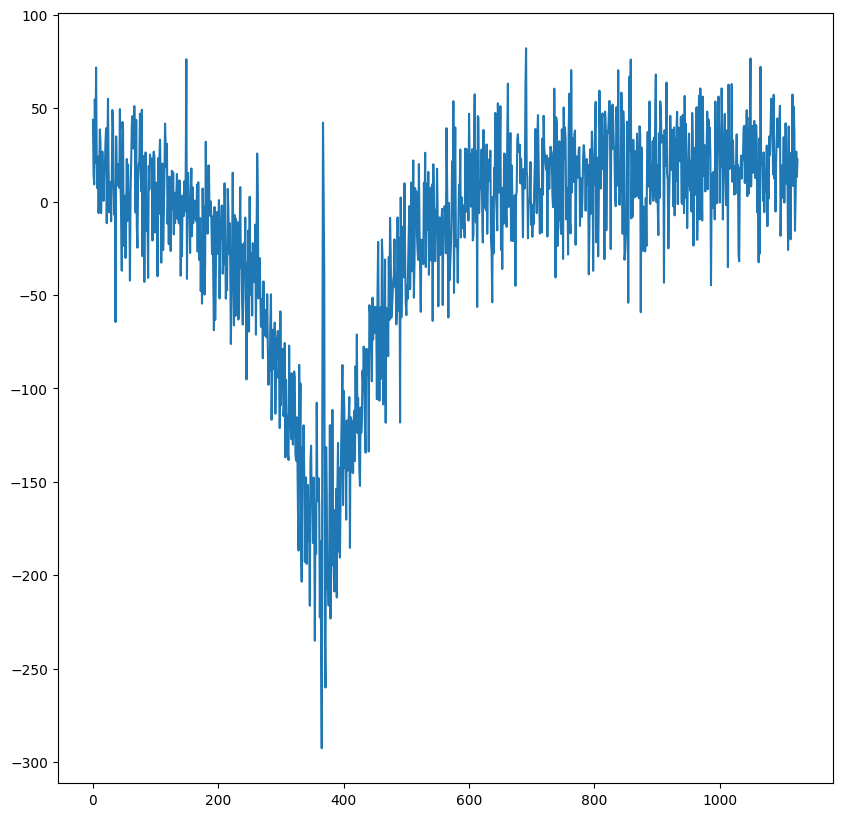

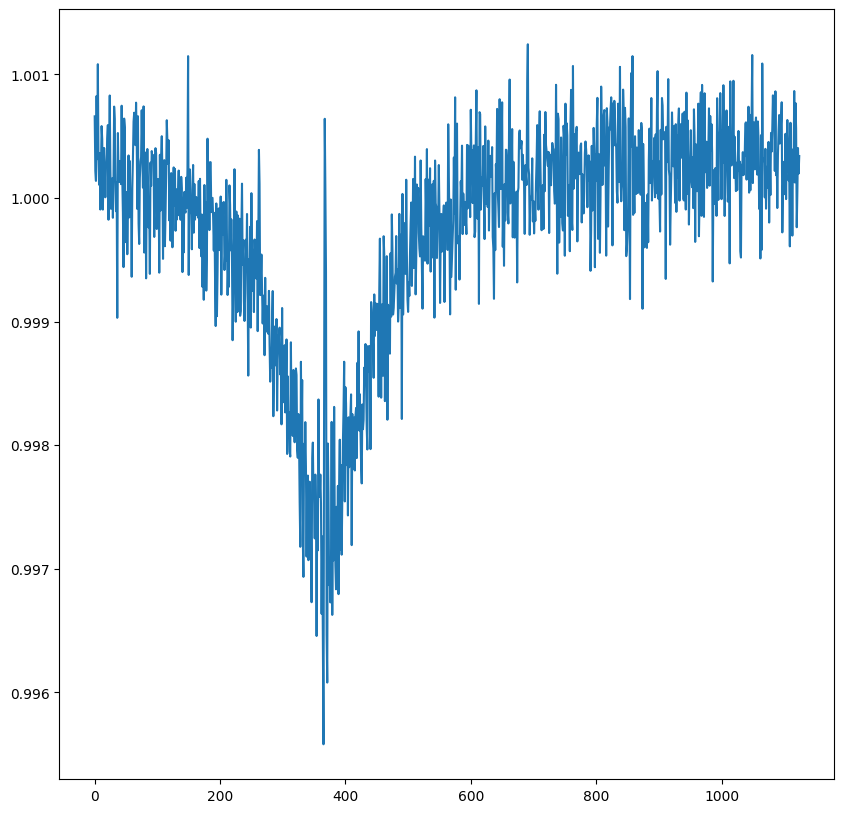

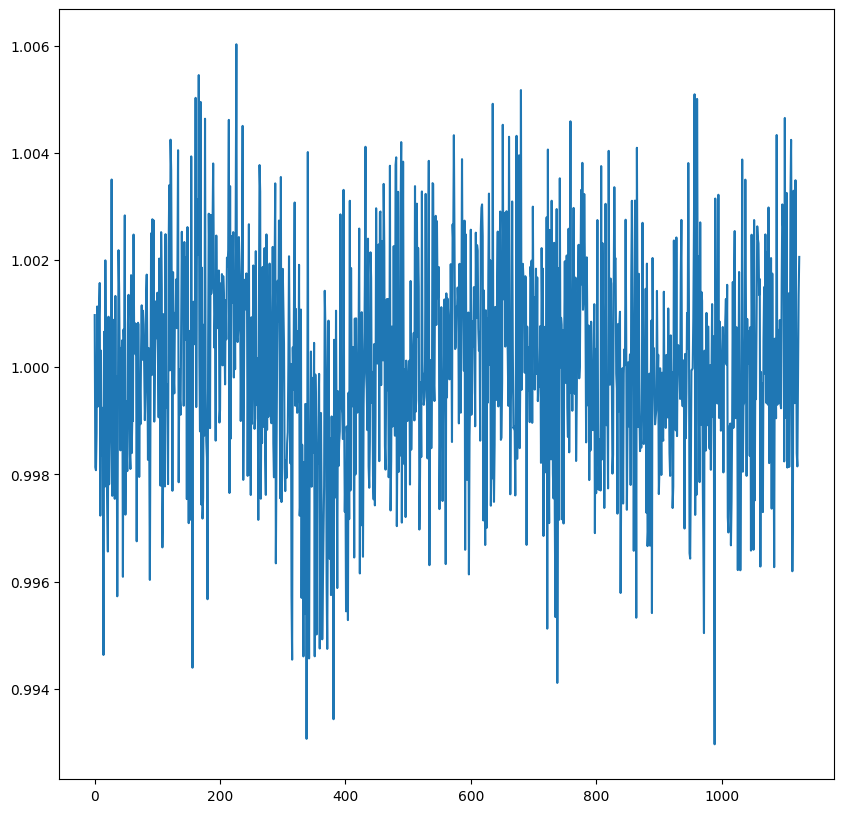

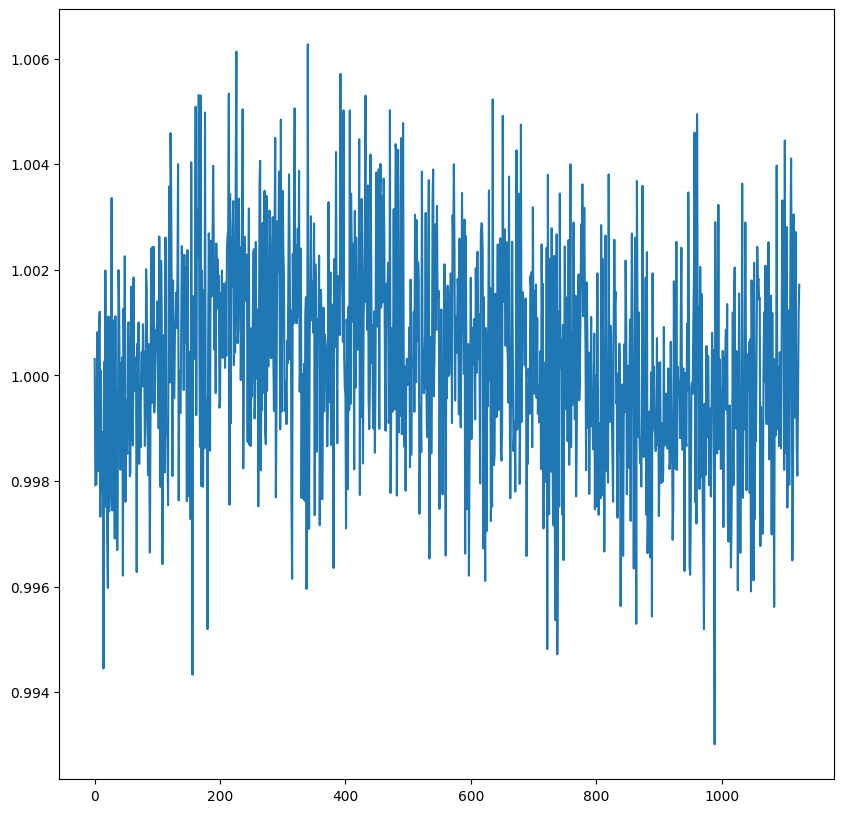

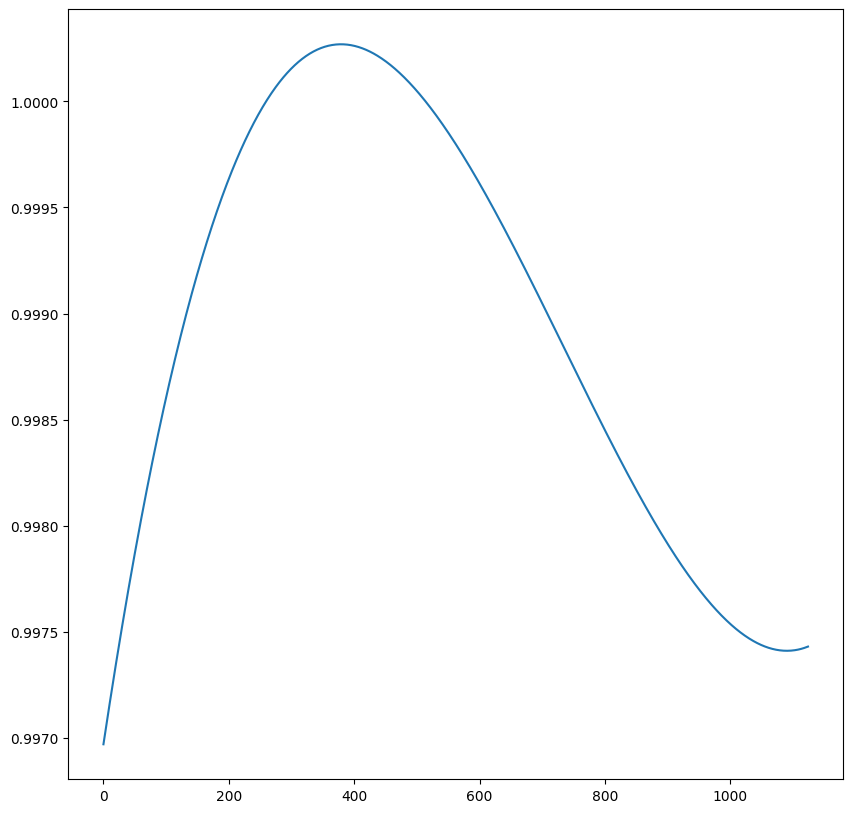

In [35]:
slic = slice(29*1125,30*1125)
plt.figure(figsize=(10,10))
plt.plot( (fit_orig-fit_new)[slic] )

plt.figure(figsize=(10,10))
plt.plot( (fit_orig/fit_new)[slic] )

plt.figure(figsize=(10,10))
y= (design_matrix_base@poly_coeffs)[:,None] * t
plt.plot( (y[:,0]/fit_new)[slic] )

plt.figure(figsize=(10,10))
y= (design_matrix_base@poly_coeffs)[:,None] * t
plt.plot( (y[:,0]/fit_orig)[slic] )

plt.figure(figsize=(10,10))
y= (design_matrix_base@poly_coeffs)[:,None]
plt.plot(y[slic])

In [24]:
t.shape

(122625, 1)

In [25]:
fit_new.shape

(122625,)

In [36]:
f

array([[-0.01672773, -0.07207183, -0.99725916],
       [ 0.00115578, -0.99739944,  0.07206258]])